In [5]:
!pip install pycaret
!pip install pycaret[analysis]
!pip install shap

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import shap
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.


(175218, 46)
Linear regression mse = 8.499027220021073 and rmse = 2.9153091122591226


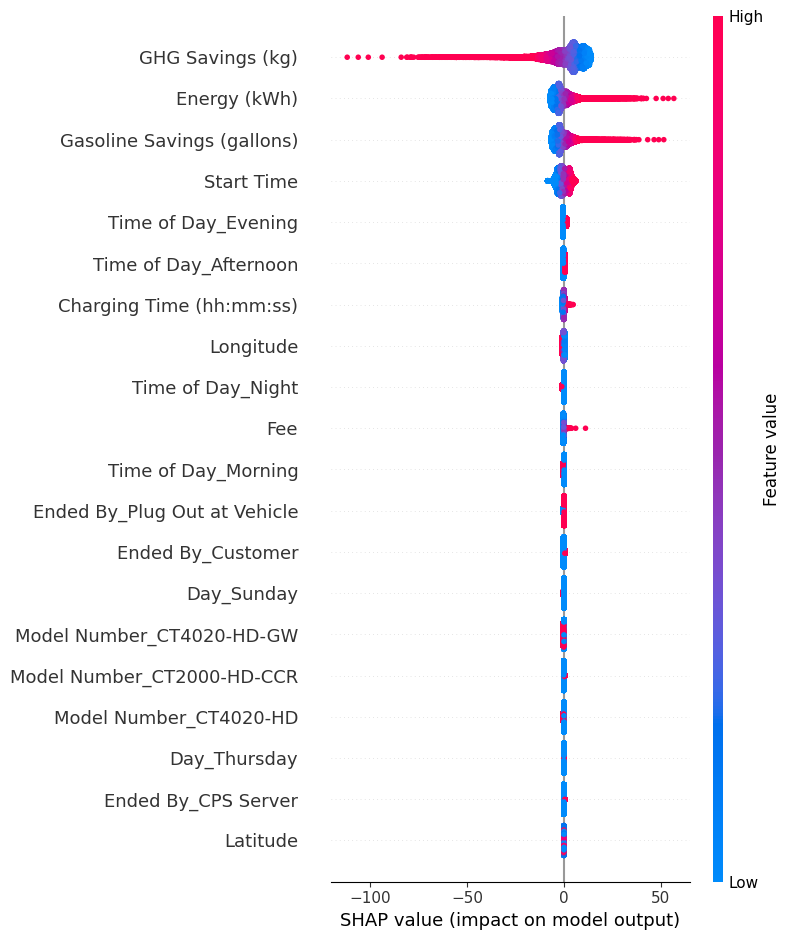

XGBoost regression mse = 2.700544632103903 and rmse = 1.6433333904305307


[22:27:32] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


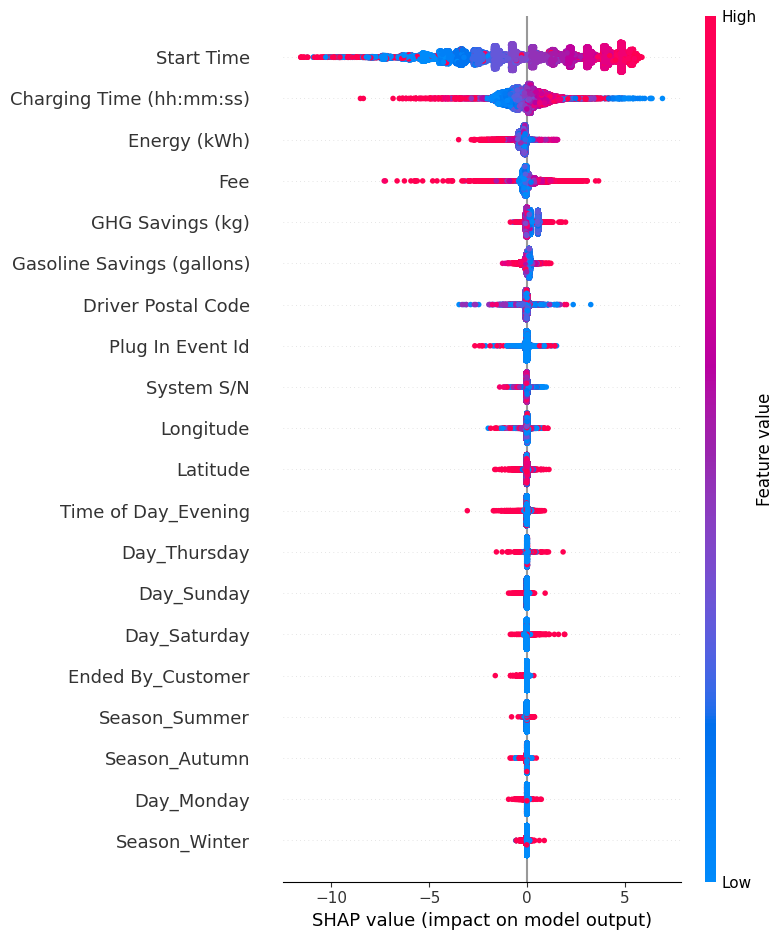

Decision Tree regression mse = 5.459194155918274 and rmse = 2.3364918480316326


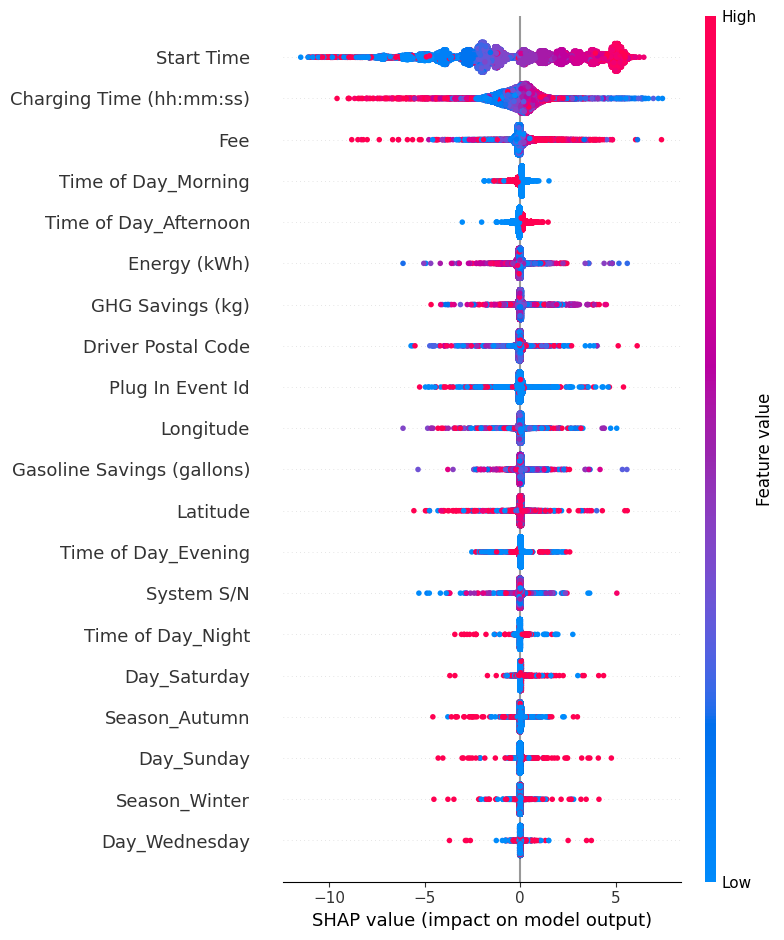

In [4]:
# Columns to drop, these have little to no significance
columns_to_drop = [
    "Station Name", "MAC Address", "Org Name", "Transaction Date (Pacific Time)",
    "Total Duration (hh:mm:ss)", "End Time Zone", "EVSE ID", "City",
    "State/Province", "Postal Code", "Country", "Currency", 'Start Time Zone', 'Address 1', 'County',
]

# Function to get season
def get_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Autumn'
    else:
        return 'Winter'

# Function to categorize time of day (in hours)
def categorize_time(hour):
    if 0 <= hour < 5:
        return 'Mid_night'
    elif 5 <= hour < 11:
        return 'Morning'
    elif 11 <= hour < 16:
        return 'Afternoon'
    elif 16 <= hour < 19:
        return 'Evening'
    else:
        return 'Night'

# Path to the CSV file
path_to_csv = "/content/EVChargingStationUsage.csv"

# Loading and preprocessing data
data = pd.read_csv(path_to_csv)

# Feature Engineering
data.drop(columns=columns_to_drop + ['Start Time Zone', 'End Time Zone', 'Address 1', 'County'], inplace=True)  # Dropping additional columns
data['Start Date'] = pd.to_datetime(data['Start Date'], errors='coerce')
data['Season'] = data['Start Date'].dt.month.apply(get_season)
data['Day'] = data['Start Date'].dt.day_name()
data['Start Time'] = data['Start Date'].dt.hour  # Extracting the hour from 'Start Date'
data.drop(columns=['Start Date'], inplace=True)  # Dropping the original Start Date column
data = pd.get_dummies(data, columns=['Port Type', 'Ended By', 'Plug Type', 'Model Number'])  # One-hot encoding 'Model Number'
data['End Date'] = pd.to_datetime(data['End Date'], errors='coerce').dt.hour  # Extracting the hour from 'End Date'
data.drop(columns=['User ID'], inplace=True)  # Dropping 'User ID' column
data['Charging Time (hh:mm:ss)'] = data['Charging Time (hh:mm:ss)'].apply(
    lambda x: int(x.split(':')[0]) * 3600 + int(x.split(':')[1]) * 60 + int(x.split(':')[2])  # Converting duration to seconds
)
data['Time of Day'] = data['Start Time'].apply(categorize_time)  # Finding the category of the day when charging started

# Dropping rows with missing values
data.dropna(inplace=True)
print(data.shape)

# Splitting data
X = data.drop(columns=['End Date'])
y = data['End Date']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One-hot encoding
X_train_encoded = pd.get_dummies(X_train, columns=['Season', 'Day', 'Time of Day'])
X_test_encoded = pd.get_dummies(X_test, columns=['Season', 'Day', 'Time of Day'])
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, axis=1, fill_value=0)

# Linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_encoded, y_train)
y_pred_lin_reg = lin_reg.predict(X_test_encoded)
mse_lin_reg = mean_squared_error(y_test, y_pred_lin_reg)
rmse_lin_reg = np.sqrt(mse_lin_reg)
print(f'Linear regression mse = {mse_lin_reg} and rmse = {rmse_lin_reg}')

# SHAP for linear regression
explainer_lin_reg = shap.LinearExplainer(lin_reg, X_train_encoded)
shap_values_lin_reg = explainer_lin_reg.shap_values(X_test_encoded)
shap.initjs()
shap.force_plot(explainer_lin_reg.expected_value, shap_values_lin_reg[0, :], X_test_encoded.iloc[0, :])

shap.summary_plot(shap_values_lin_reg, X_test_encoded)


# XGBoost model
xgb_model_default = XGBRegressor(random_state=42)
xgb_model_default.fit(X_train_encoded, y_train)
y_pred_xgb_default = xgb_model_default.predict(X_test_encoded)

mse_xgb_default = mean_squared_error(y_test, y_pred_xgb_default)
rmse_xgb_default = np.sqrt(mse_xgb_default)
print(f'XGBoost regression mse = {mse_xgb_default} and rmse = {rmse_xgb_default}')

# SHAP for XGBoost
explainer_xgb = shap.TreeExplainer(xgb_model_default)
shap_values_xgb = explainer_xgb.shap_values(X_test_encoded)
shap.initjs()
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[0, :], X_test_encoded.iloc[0, :])
shap.summary_plot(shap_values_xgb, X_test_encoded)


# Decision Tree model (replace Random Forest)
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train_encoded, y_train)
y_pred_dt = dt_model.predict(X_test_encoded)

mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
print(f'Decision Tree regression mse = {mse_dt} and rmse = {rmse_dt}')

# SHAP for Decision Tree
explainer_dt = shap.TreeExplainer(dt_model)
shap_values_dt = explainer_dt.shap_values(X_test_encoded)
shap.initjs()
shap.force_plot(explainer_dt.expected_value, shap_values_dt[0, :], X_test_encoded.iloc[0, :])
shap.summary_plot(shap_values_dt, X_test_encoded)


# Saving the mse and rmse in the dictionary
mse_rmse_dict = {
    'linear_regression': {'mse': mse_lin_reg, 'rmse': rmse_lin_reg},
    'xgboost': {'mse': mse_xgb_default, 'rmse': rmse_xgb_default},
    'decision_tree': {'mse': mse_dt, 'rmse': rmse_dt},
}

# Saving the dictionary as a JSON file
json_file_path = 'result.json'
with open(json_file_path, 'w') as json_file:
    json.dump(mse_rmse_dict, json_file, indent=4)


In [6]:
from pycaret.regression import *

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dt,Decision Tree Regressor,0.7907,5.4365,2.3300,0.7000,0.2828,0.0693,1.9230
lr,Linear Regression,1.6178,8.5226,2.9192,0.5296,0.3101,0.1624,1.0470
ridge,Ridge Regression,1.6172,8.5236,2.9193,0.5296,0.3101,0.1624,0.4350


Processing:   0%|          | 0/17 [00:00<?, ?it/s]

DecisionTreeRegressor(random_state=42)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.7284,3.0014,1.7325,0.8321,0.2101,0.0650
1,0.7479,3.4706,1.8629,0.8103,0.2257,0.0688
2,0.7392,3.3936,1.8422,0.8128,0.2261,0.0628
3,0.7541,3.5542,1.8853,0.8035,0.2308,0.0718
4,0.7390,3.1308,1.7694,0.8271,0.2231,0.0621
5,0.7533,3.4133,1.8475,0.8103,0.2236,0.0650
6,0.7575,3.4898,1.8681,0.8087,0.2254,0.0688
7,0.7297,2.9449,1.7161,0.8388,0.2162,0.0669
8,0.7518,3.2745,1.8096,0.8196,0.2264,0.0700


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Transformation Pipeline and Model Successfully Saved


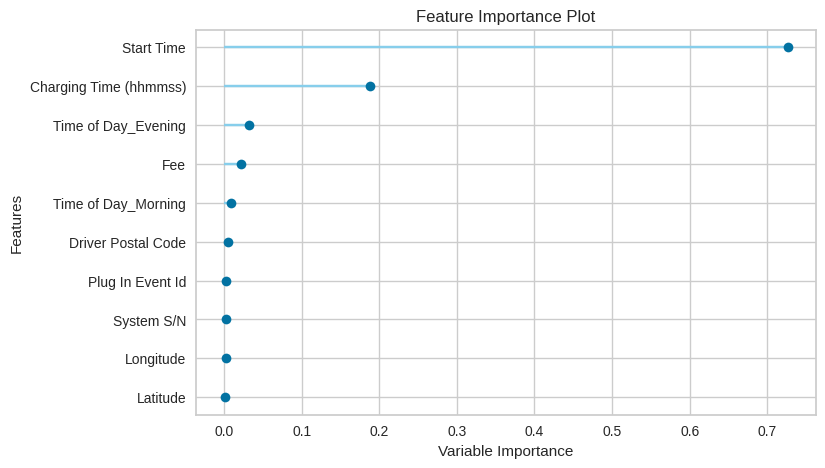

In [8]:
# Initialize the setup for regression
reg = setup(data, target='End Date', verbose=False, session_id=42)

# Compare selected regression models with potentially faster runtimes
best_model = compare_models(include=['lr', 'ridge', 'dt'])

# Display the best model's parameters and hyperparameters
print(best_model)

# tune the best model
tuned_model = tune_model(best_model)

# Save the best model
save_model(tuned_model, 'best_regression_model')

# Plot feature importance for the tuned_model (works for some regression models)
plot_model(tuned_model, plot='feature')


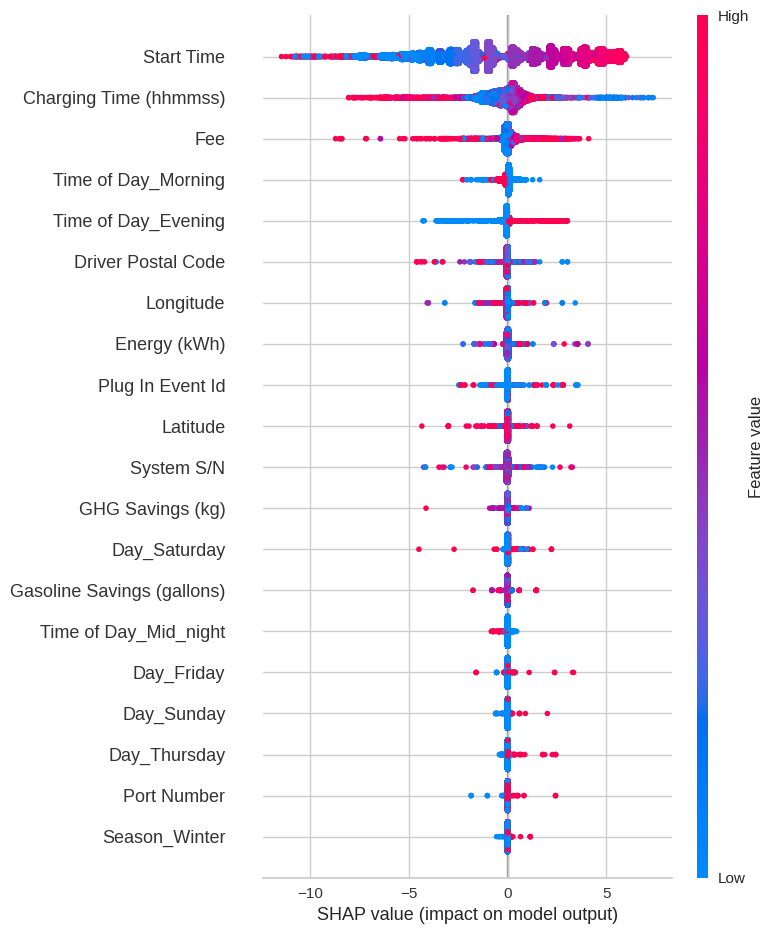

In [9]:
# Interpret Decision Tree Regressor, as it's best one
interpret_model(tuned_model)

In [11]:
# Fit the best model obtained from compare_models() on the training data
best_model = compare_models(include=['dt'])

# Run predictions on the test data
y_pred = predict_model(best_model, data=X_test)

# Check the column names in the y_pred DataFrame
print(y_pred.columns)

# Calculate error metrics
if 'End Time' in y_pred.columns:
    mse = mean_squared_error(y_test, y_pred['End Time'])
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred['End Time'])

    # Print error metrics
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'R-squared (R2): {r2}')



,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dt,Decision Tree Regressor,0.7907,5.4365,2.3300,0.7000,0.2828,0.0693,1.9820


Processing:   0%|          | 0/9 [00:00<?, ?it/s]

Index(['Charging Time (hh:mm:ss)', 'Energy (kWh)', 'GHG Savings (kg)',
       'Gasoline Savings (gallons)', 'Port Number', 'Latitude', 'Longitude',
       'Fee', 'Plug In Event Id', 'Driver Postal Code', 'System S/N', 'Season',
       'Day', 'Start Time', 'Port Type_Level 1', 'Port Type_Level 2',
       'Ended By_CPS Server', 'Ended By_Customer', 'Ended By_Door',
       'Ended By_Door Closed', 'Ended By_Door Open',
       'Ended By_Final 4-strikes GFCI trip', 'Ended By_Final GFCI Tripped',
       'Ended By_Holster Plugin', 'Ended By_OCD',
       'Ended By_Outlet Unreachable', 'Ended By_Plug Out at Station',
       'Ended By_Plug Out at Vehicle', 'Ended By_Plug Removed While Rebooting',
       'Ended By_Relay Stuck Closed', 'Ended By_Station Offline',
       'Ended By_Unknown', 'Plug Type_J1772', 'Plug Type_NEMA 5-20R',
       'Model Number_CT2000-HD-CCR', 'Model Number_CT2000-HD-GW1-CCR',
       'Model Number_CT2100-HD-CCR', 'Model Number_CT2100-HD-CDMA-CCR',
       'Model Number_CT401